In [1]:
from math import *
from numpy import sign

import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib
import matplotlib.cbook 
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rand

from matplotlib import rc


rc('text', usetex=True)
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=20)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=20)

matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{graphics,graphicx,rotating}'
]

%matplotlib inline  



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
num=1000
def get(num):
    ! cd ntuple_Tchannel
    mylist=! ls ntuple_Tchannel/tchannel_up_$num*.evt
    return mylist

get(1000)

['ntuple_Tchannel/tchannel_up_1000_rinv0.01.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.1.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.2.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.3.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.4.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.5.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.6.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.7.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.8.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.98.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.99.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.9.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv1.0.evt']

### Read input

In [9]:
def readfile(name, folder='ntuple_Tchannel/', lumi=1, cxn=None):
    data = pd.read_csv(folder+name+'.evt', header=0, delimiter=',', skipinitialspace=True)
    data.meta = pd.read_csv(folder+name+'.meta', header=0, delimiter=',', skipinitialspace=True)
    if 'weight' in data.columns:
        data['weight'] *= (data.meta['cxn']*lumi/data.meta['sum_weight'])[0]
    else:
        data['weight'] = (data.meta['cxn']*lumi / data.meta['nevt'])[0]  
    if cxn is not None:
        data['weight'] = (cxn*lumi / data.meta['nevt'])[0]  
    return data

bkg = ['bkg_ttbar_dilep_0',  'bkg_ttbar_semilep_0',  'bkg_Wj_0',  'bkg_Zj_0']
bkg = [ readfile(f,folder='ntuple_Zprime/') for f in bkg ]

def nbkg(cut, lumi=37*1000):
    mybkg = [ f.query(cut) for f in bkg ]
    myevt = np.asarray([ lumi*np.sum(f['weight']) for f in mybkg ])
    return myevt

b = 10**np.linspace(log10(500),log10(10000),101)

cxn3000= .03951
cxn5000= .0103

def get_sig(mass):
    sigup = ['tchannel_up_mass_rinv0.01',
        'tchannel_up_mass_rinv0.1',
        'tchannel_up_mass_rinv0.2',
        'tchannel_up_mass_rinv0.3',
        'tchannel_up_mass_rinv0.4',
        'tchannel_up_mass_rinv0.5',
        'tchannel_up_mass_rinv0.6',
        'tchannel_up_mass_rinv0.7',
        'tchannel_up_mass_rinv0.8',
        'tchannel_up_mass_rinv0.9',
        'tchannel_up_mass_rinv0.98',
        'tchannel_up_mass_rinv0.99',
        'tchannel_up_mass_rinv1.0'
        ]
    
    sigdown = ['tchannel_down_mass_rinv0.01',
        'tchannel_down_mass_rinv0.1',
        'tchannel_down_mass_rinv0.2',
        'tchannel_down_mass_rinv0.3',
        'tchannel_down_mass_rinv0.4',
        'tchannel_down_mass_rinv0.5',
        'tchannel_down_mass_rinv0.6',
        'tchannel_down_mass_rinv0.7',
        'tchannel_down_mass_rinv0.8',
        'tchannel_down_mass_rinv0.9',
        'tchannel_down_mass_rinv0.98',
        'tchannel_down_mass_rinv0.99',
        'tchannel_down_mass_rinv1.0'
        ]
    
    sigup = [ s.replace('mass',str(mass)) for s in sigup ]
    sigdown = [ s.replace('mass',str(mass)) for s in sigdown ]
    
    sigup = [ readfile(f) for f in sigup ]
    sigup_cxn = [ f.meta['cxn'] for f in sigup ]
    
    sigdown = [ readfile(f) for f in sigdown ]
    sigdown_cxn = [ f.meta['cxn'] for f in sigdown ]
    
    #sig_Mt = [ np.histogram(f['Mt'],bins=b,weights=f['weight'])[0] for f in sigup ]
    return [ sigup, sigdown ]

sig1000=get_sig(1000)
sig5000=get_sig(5000)

In [11]:
def nsig(sig, cut, lumi=37*1000, mix=[4./(4./3 *.59)**2 , 4./(2./3 *.59)**2]):
    [ sig1, sig2 ] = sig
    mysig1 = [ f.query(cut) for f in sig1 ]
    mysig2 = [ f.query(cut) for f in sig2 ]
    
    myevt1 = np.asarray([ mix[0]*lumi*np.sum(f['weight']) for f in mysig1 ])
    myevt2 = np.asarray([ mix[1]*lumi*np.sum(f['weight']) for f in mysig2 ])
    
    return myevt1+myevt2

In [12]:
cutlist1=['MEt > 1000 & dphi <.4', 'MEt > 1200 & dphi <.4', 
          'MEt > 1000 & dphi <.4 & pt3 > 80', 'MEt > 1200 & dphi <.4 & pt3 > 80',
          'MEt > 1000 & dphi <.4 & pt3 > 100', 'MEt > 1200 & dphi <.4 & pt3 > 100',
         ]

cutlist2=['MEt > 800 & dphi >.4', 'MEt > 1000 & dphi >.4', 'MEt > 1200 & dphi >.4',
          'MEt > 800 & dphi >.4 & pt3 > 80', 'MEt > 1000 & dphi >.4 & pt3 > 80', 'MEt > 1200 & dphi >.4 & pt3 > 80',
          'MEt > 800 & dphi >.4 & pt3 > 100', 'MEt > 1000 & dphi >.4 & pt3 > 100', 'MEt > 1200 & dphi >.4 & pt3 > 100'        
         ]

commoncut=' & pt3 > 50'

cutnbkg1=[ np.sum(nbkg(c+commoncut)) for c in cutlist1 ]
cutnbkg2=[ np.sum(nbkg(c+commoncut)) for c in cutlist2 ]

cutnsig1=[ nsig(sig1000, c+commoncut) for c in cutlist1 ]
cutnsig2=[ nsig(sig1000, c+commoncut) for c in cutlist2 ]


cutnsig1_5000=[ nsig(sig5000, c+commoncut) for c in cutlist1 ]
cutnsig2_5000=[ nsig(sig5000, c+commoncut) for c in cutlist2 ]


from scipy.optimize import bisect
def limit(nbkg):
    
    def func_root(x):
        logpart = x-nbkg*np.log(1+x/nbkg)
        my_val = logpart - 2.0
        return my_val
    
    soln = bisect(func_root, 0,10*nbkg)
    return soln

def limit_list(nbkg):
    return np.asarray([ limit(n) for n in nbkg ])

cutlim1 = [ limit(n) for n in cutnbkg1 ]
cutlim2 = [ limit(n) for n in cutnbkg2 ]

exc_sig_factor1 = np.asarray([ cutlim1[i]/l for i,l in enumerate(cutnsig1)])
exc_sig_factor2 = np.asarray([ cutlim2[i]/l for i,l in enumerate(cutnsig2)])

exc_sig_factor1_5000 = np.asarray([ cutlim1[i]/l for i,l in enumerate(cutnsig1_5000)])
exc_sig_factor2_5000 = np.asarray([ cutlim2[i]/l for i,l in enumerate(cutnsig2_5000)])


exc_sig_factor1 = np.amin(exc_sig_factor1, axis=0)
exc_sig_factor2 = np.amin(exc_sig_factor2, axis=0)

exc_sig_factor1_5000 = np.amin(exc_sig_factor1_5000, axis=0)
exc_sig_factor2_5000 = np.amin(exc_sig_factor2_5000, axis=0)


print(exc_sig_factor1)
print(exc_sig_factor2)

cutoff1 = 1000./exc_sig_factor1**(1./4)
cutoff2 = 1000./exc_sig_factor2**(1./4)

cutoff1_5000 = 5000./exc_sig_factor1_5000**(1./4)
cutoff2_5000 = 5000./exc_sig_factor2_5000**(1./4)

print(cutoff1)

[ 156.98661239   10.86901049    4.14806001    2.50078512    1.6021459
    1.25317874    1.04535507    1.03705401    1.21107788    2.150262
   11.70302492   21.90823648   79.89680761]
[ 2122.06111835   278.05560057   125.45094176    55.14733096    20.2739759
    13.61627678     9.00731137     5.293088       4.85954329     5.44623712
     7.55917156     8.71266451    10.43068528]
[ 282.51033851  550.74745384  700.71068865  795.20830269  888.84182948
  945.14130937  988.97210495  990.94524088  953.25036818  825.80432896
  540.66152805  462.21937394  334.47806593]


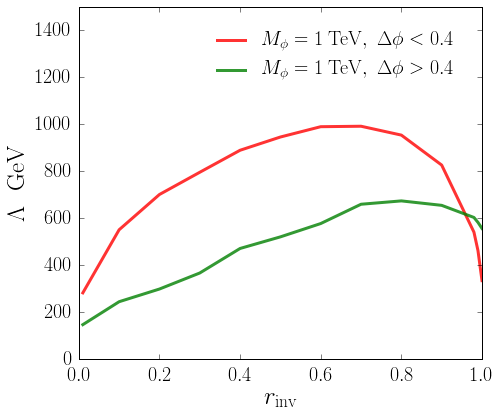

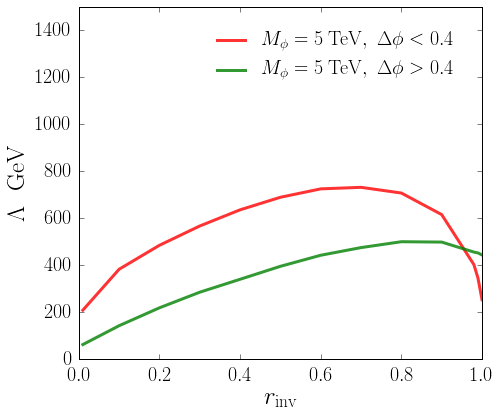

In [14]:
plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

rinv=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1]

plt.plot(rinv,cutoff1,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi < 0.4$',lw=3,alpha=.8,c='red')
plt.plot(rinv,cutoff2,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi > 0.4$',lw=3,alpha=.8,c='green')

plt.ylim([0,1500])
plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ \Lambda\,\,{\rm\; GeV}$', fontsize=25)

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.savefig("cutoff_tchannel_associated_1000.pdf")


plt.figure()

fig=plt.figure("5000", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

rinv=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1]

plt.plot(rinv,cutoff1_5000,label=r'$M_\phi = 5\;{\rm TeV},\; \Delta \phi < 0.4$',lw=3,alpha=.8,c='red')
plt.plot(rinv,cutoff2_5000,label=r'$M_\phi = 5\;{\rm TeV},\; \Delta \phi > 0.4$',lw=3,alpha=.8,c='green')

plt.ylim([0,1500])
plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ \Lambda\,\,{\rm\; GeV}$', fontsize=25)

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.savefig("cutoff_tchannel_associated_5000.pdf")